In [1]:
!pip install -q torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118
!pip install easyocr
!pip install langgraph langchain langchain_huggingface langchain_openai langchain_community

In [41]:
import os

# 1. colab에서 실행할 경우)

## 구글 드라이브 마운트
from google.colab import drive
drive.mount('/content/drive')
base_path = '/content/drive/MyDrive/Projects'

## 이미지 경로
imagepath_has_text = f'{base_path}/vlm실험/images/면세점지원사업.jpg'
imagepath_no_text = f'{base_path}/vlm실험/images/자전거탄사람.jpg'

env = f'{base_path}/comm/.env'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
'''
# 2. local에서 실행할 경우

base_path = './'

## 문서경로
image_has_text = f'{base_path}/vlm실험/images/면세점지원사업.pdf'
image_no_text = f'{base_path}/vlm실험/images/자전거탄사람.pdf'

env = f'{base_path}/../../comm/.env'
'''

"\n# 2. local에서 실행할 경우\n\nbase_path = './'\n\n## 문서경로\nimage_has_text = f'{base_path}/vlm실험/images/면세점지원사업.pdf'\nimage_no_text = f'{base_path}/vlm실험/images/자전거탄사람.pdf'\n\nenv = f'{base_path}/../../comm/.env'\n"

In [8]:
# env 설정
from dotenv import load_dotenv
load_dotenv(env)

True

In [23]:
# LLM 설정
from langchain_openai import ChatOpenAI
llm = ChatOpenAI(temperature=0)

In [ ]:
# 프롬프트 설정
from langchain.prompts import PromptTemplate
prompt_str = """
  당신은 친절한 상담사입니다.

  만약 첨부된 이미지 정보가 있다면,
  첨부된 이미지를 기준으로 답변하세요.

  #이미지 정보
  {image_info}

  #사용자 질문
  {query}
"""
prompt = PromptTemplate(
    template=prompt_str,
    input_varialbes=["image_info", "query"]
)

In [ ]:
# VLM 모델 설정
from transformers import BlipProcessor, BlipForConditionalGeneration
processor = BlipProcessor.from_pretrained("Salesforce/blip-image-captioning-base")
model = BlipForConditionalGeneration.from_pretrained("Salesforce/blip-image-captioning-base")

In [24]:
# 그래프 설정
from typing import Literal, Optional, TypedDict
from langgraph.graph import StateGraph, END, START

In [86]:
# 서비스 상태
class State(TypedDict):
  query: str # 사용자 질문
  image_file_path: Optional[str] # 업로드 이미지
  image_ocr_text: Optional[str] # 이미지 텍스트
  image_blip_caption: Optional[str] # 이미지 blip 캡션
  response: Optional[str] # 최종 응답값

In [74]:
# 노드 정의
## 노드1: 이미지에서 OCR로 텍스트 추출
import easyocr

def extract_ocr_text(state: State):
  print("node - extract_ocr_text")
  reader = easyocr.Reader(['ko', 'en'], gpu=True)
  get_text = []
  result = reader.readtext(state["image_file_path"])

  # 텍스트가 없는 경우
  if not result:
    return {"image_ocr_text": ""}

  for detection in result:
    get_text.append(detection[1].strip())
  return {"image_ocr_text": "\n".join(get_text)}

In [75]:
## 노드2: VLM-BLIP 모델 실행
from PIL import Image as pilImage
def get_blip_caption(state: State):
  print("node - get_blip_caption")

  ## 이미지 처리
  image = pilImage.open(state["image_file_path"])
  inputs = processor(image, return_tensors="pt")

  ## 이미지 캡셔닝
  output = model.generate(**inputs)
  caption = processor.decode(output[0], skip_special_tokens=True)
  return {"image_blip_caption": caption}

In [87]:
## 노드3: 최종프롬프트를 LLM에 전달
def generate_response(state: State):
  print("node - generate_response")

  # 이미지 정보
  image_info = "정보 없음"
  if state["image_blip_caption"] is not None:
    image_info = state["image_blip_caption"]
  elif state["image_ocr_text"] is not None:
    image_info = state["image_ocr_text"]

  # 프롬프트 생성
  formatted_prompt = prompt.format(
      image_info=image_info,
      query=state["query"]
  )

  # llm 실행
  response = llm.invoke(formatted_prompt)
  content = response.content if hasattr(response, "content") else str(response)
  return {"response": content}

In [89]:
# 조건부 엣지 정의
## 엣지1: 요청이 텍스트인지 확인
def check_input_type(state: State):
  if state["image_file_path"] is None:
    return "text_input"
  if os.path.isfile(state["image_file_path"]):
    return "image_input"
  raise FileNotFoundError(f'파일이 존재하지 않습니다: {state["image_file_path"]}')

In [91]:
# OCR 텍스트의 최소 길이
ocr_min_text_length = 20

## 엣지2: OCR텍스트 길이 판단후 VLM 전달 여부
def is_short_ocr_text(state: State):
  if state["image_ocr_text"] is None or len(state["image_ocr_text"]) < ocr_min_text_length:
    return "short_ocr_text"
  return "long_ocr_text"

In [92]:
# 그래프 생성
graph = StateGraph(State)

# 노드추가
graph.add_node("extract_ocr_text", extract_ocr_text)
graph.add_node("get_blip_caption", get_blip_caption)
graph.add_node("generate_response", generate_response)

# 엣지연결
graph.add_conditional_edges(
  START,
  check_input_type,
  {
    "text_input": "generate_response",
    "image_input": "extract_ocr_text"
  }
)
graph.add_conditional_edges(
  "extract_ocr_text",
  is_short_ocr_text,
  {
    "short_ocr_text": "get_blip_caption",
    "long_ocr_text": "generate_response"
  }
)
graph.add_edge("get_blip_caption", "generate_response")
graph.add_edge("generate_response", END)

In [93]:
builder = graph.compile()

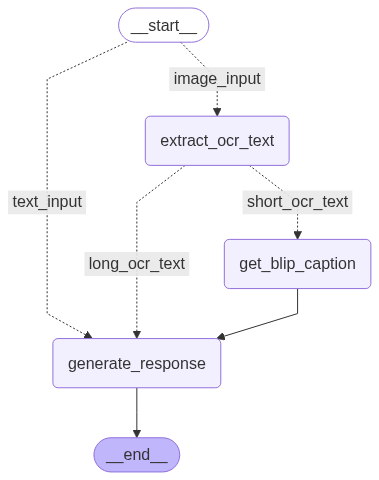

In [94]:
# 그래프 시각화
from IPython.display import Image, display
display(Image(builder.get_graph().draw_mermaid_png()))

In [96]:
# 텍스트 없는 이미지 업로드 경우
## 초기 상태 정의
no_text_state = State(
  query="자전거를 탄 사람은 몇명입니까?",
  image_file_path=imagepath_no_text,
  image_ocr_text=None,
  image_blip_caption=None,
  response=None
)

## 실행
no_text_response = builder.invoke(no_text_state)
print("no_text_response", no_text_response)

node - extract_ocr_text
node - get_blip_caption
node - generate_response
no_text_response {'query': '자전거를 탄 사람은 몇명입니까?', 'image_file_path': '/content/drive/MyDrive/Projects/vlm실험/images/자전거탄사람.jpg', 'image_ocr_text': '', 'image_blip_caption': 'two people riding bikes down a street', 'response': '이미지에는 두 명의 사람이 자전거를 타고 거리를 따라 이동하고 있는 것으로 보입니다. 따라서 자전거를 탄 사람은 두 명입니다.'}


In [98]:
# 텍스트 있는 이미지 업로드 경우
## 초기 상태 정의
has_text_state = State(
  query="문의처를 알려주세요.",
  image_file_path=imagepath_has_text,
  image_ocr_text=None,
  image_blip_caption=None,
  response=None
)

## 실행
has_text_response = builder.invoke(has_text_state)
print("has_text_response", has_text_response)

node - extract_ocr_text
node - generate_response
has_text_response {'query': '문의처를 알려주세요.', 'image_file_path': '/content/drive/MyDrive/Projects/vlm실험/images/면세점지원사업.jpg', 'image_ocr_text': 'sba 서울경제진흥원\n20259\n물내해외 [점 진출 죄원업\n해외 일본 공항면세점 입점\n지원기업 모집\n모집기간\n2025.5.22. (목) ~ 6. 5. (목)\n모집 개요\n모집대상: 자사 브랜드틀 보유한 서울시 중소기업 m본사 지사 연구소등 서울소재필수\n모집규모: 20개사 내외\n모집품목: 화장품 품목 기반 분티 카테고리\n신청방법: SBA 흉페이지(sba.seoul.kr) 내 온라인 신청\n신청기간: 25.5. 22 (목)\n6.5.(목) 17:00까지\n온라인 사업설명회: 25.5. 30 (금) 14시 예정\n참여 방법: 공고문 내 캐치시규 품을 통한 신청\n지원 내용\n일본 하네다 공항면세점 내 SBA 기획관 입점 및 운영 지원\n현지 상황에 따라 나리타 공항면세점 간사이 공항면세점 등으로 입점 위치가 변경월 수 있습니다.\n입점 기념 사은품 증정행사 한정판 제품 판매 SNS 활용 마켓팅 등\n현지 특화 프로모선 지원\n입점 운영을 위한 물류비 지원 후생성 등록 및 인종 제품 라빌렁 등 현지화 지원\n문의처: 02-2657-5706\ninnuy@sba.seoulkr\n02-2657-5803\npromotion_lee@sbaseoulkr\n육의사항 등의 세부 내용은 하단의 모집 공고문 참조 바람니다', 'image_blip_caption': None, 'response': '문의처는 다음과 같습니다:\n전화번호: 02-2657-5706\n이메일: innuy@sba.seoul.kr\n팩스번호: 02-2657-5803\n이메일: promotion_lee@sba.seoul.kr\n\n더 자세한 내용은 하단의 모집 공

In [99]:
# 이미지 업로드가 없는 경우
# 초기 상태 정의
only_text_state = State(
  query="문의처를 알려주세요.",
  image_file_path=None,
  image_ocr_text=None,
  image_blip_caption=None,
  response=None
)

# 실행
only_text_response = builder.invoke(only_text_state)
print("only_text_response", only_text_response)

node - generate_response
only_text_response {'query': '문의처를 알려주세요.', 'image_file_path': None, 'image_ocr_text': None, 'image_blip_caption': None, 'response': '안녕하세요! 문의해 주셔서 감사합니다. 문의처는 저희 회사의 고객센터로 연락 주시면 도움을 드릴 수 있습니다. 고객센터 전화번호는 02-1234-5678이며 이메일은 help@company.com입니다. 언제든지 문의 주시면 친절히 안내해 드리겠습니다. 추가로 궁금한 사항이 있으시면 언제든지 물어보세요!'}
